In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import pandas as pd # handle dataset processing
import torch # pytorch framework for deep learning
import torch.nn as nn
import re # regular expressions for text cleaning
import nltk # natural language toolkit for text cleaning
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertModel # hugging face library for bert
from sklearn.model_selection import train_test_split # split data
from torch.utils.data import DataLoader, TensorDataset # help create batches for training

# Data Preprocessing

## Load Dataset

In [ ]:
# Load and preprocess the data
data = pd.read_csv("/content/drive/MyDrive/uber_reviews_without_reviewid.csv")

## Remove redundant columns

In [ ]:
data.columns

Index(['userName', 'userImage', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt',
       'appVersion'],
      dtype='object')

Remove unnecessary columns

In [ ]:
data.drop(columns=['userName','userImage','thumbsUpCount','reviewCreatedVersion','at','replyContent','repliedAt','appVersion'], inplace=True)

In [ ]:
data.shape

(12000, 2)

In [ ]:
data.columns

Index(['content', 'score'], dtype='object')

Check missing values

In [ ]:
# check for sum of null values
data.isnull().sum()

Text Cleaning Function

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|@\S+', '', text) # Remove URLs and mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters - only characters needed
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words] # Remove stopwords
    return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Apply cleaning function

In [ ]:
data['cleaned_comment'] = data['content'].apply(clean_text) # apply cleaning

Convert Ratings into Sentiment classification if > 3 - Positive[1] else Negative[0]

In [ ]:
data['sentiment'] = data['score'].apply(lambda x: 1 if x >= 3 else 0)  # 1 - positive 0 - negative

In [ ]:
data.tail()

,content,score,sentiment
11995,Excellent!!!,5,1
11996,Worst experience after 10pm in Hyde cityno aut...,5,1
11997,Exceptional,5,1
11998,Good Service.,5,1
11999,"Very bad experience with this app, booked a sh...",1,0


Prepare data for bert tokenization

In [ ]:
# Extract cleaned comments and corresponding sentiment labels into lists.
texts = data['cleaned_comment'].tolist()
labels = data['sentiment'].tolist()

Load Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # loading bert tokenizer 
encodings = tokenizer(texts, truncation=True, padding=True, max_length=256) # convert each review into lowercase,split into words pieces(tokens) + map to a numver using bert's dictionary
# cuts off long seqeuence - truncation + add zeros to end it too short -padding

Convert encodings to tensors

In [ ]:
input_ids = torch.tensor(encodings['input_ids']) # convert tokenized texts into a tensor for model training [ used as input]
attention_masks = torch.tensor(encodings['attention_mask'])  #  - ignore padding tokens [0],pay attention to real - 1
labels = torch.tensor(labels) #  Converts sentiment labels (0 = negative, 1 = positive) into a tensor, stores labels as tensor for training

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Split the data

In [ ]:
# Train-test split Splits 80% for training and 20% for validation.
train_ids, val_ids, train_masks, val_masks, train_labels, val_labels = train_test_split(input_ids, attention_masks, labels, test_size=0.2, random_state=42)

Prepare data for training

In [ ]:
train_dataset = TensorDataset(train_ids, train_masks, train_labels)
val_dataset = TensorDataset(val_ids, val_masks, val_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) #  Trains in groups of 8 reviews at a time and random training data
val_loader = DataLoader(val_dataset, batch_size=8)

In [ ]:
# Model definition
class Sentiment(nn.Module):
    def __init__(self):
        super(Sentiment, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased') # extracts embeddings (word representations) - bert
        self.lstm = nn.LSTM(768, 128, batch_first=True, bidirectional=True) # lstm layer
        self.dropout = nn.Dropout(0.3) # prevent overfitting
        self.fc = nn.Linear(256, 2) # Fully connected layer for classification

    def forward(self, input_ids, attention_mask):
        with torch.no_grad(): # freeze bert(only lstm to train)
            embeddings = self.bert(input_ids, attention_mask)[0]
        lstm_out, _ = self.lstm(embeddings) #   embeddings through a bidirectional LSTM to capture sequential context.
        out = torch.cat((lstm_out[:, -1, :128], lstm_out[:, 0, 128:]), dim=1) #  Concatenate both LSTM directions
        out = self.dropout(out)
        return self.fc(out) # Final classification to predict sentiment positive/negative

In [ ]:
# Instantiate model
model = Sentiment()

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss() # use CrossEntropyLoss (classification loss)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # Uses AdamW optimizer with a learning rate of 2e-5. - improvr learning

# Training loop
epochs = 20
model.train()

for epoch in range(epochs):
    total_loss = 0
    for ids, masks, lbls in train_loader:
        ids, masks, lbls = ids.to(device), masks.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(ids, masks)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/20, Loss: 0.3452
Epoch 2/20, Loss: 0.2197
Epoch 3/20, Loss: 0.2066
Epoch 4/20, Loss: 0.2039
Epoch 5/20, Loss: 0.1976
Epoch 6/20, Loss: 0.1974
Epoch 7/20, Loss: 0.1928
Epoch 8/20, Loss: 0.1870
Epoch 9/20, Loss: 0.1870
Epoch 10/20, Loss: 0.1864
Epoch 11/20, Loss: 0.1787
Epoch 12/20, Loss: 0.1772
Epoch 13/20, Loss: 0.1722
Epoch 14/20, Loss: 0.1719
Epoch 15/20, Loss: 0.1721
Epoch 16/20, Loss: 0.1679
Epoch 17/20, Loss: 0.1643
Epoch 18/20, Loss: 0.1656
Epoch 19/20, Loss: 0.1605
Epoch 20/20, Loss: 0.1592


In [ ]:
# Save the model
torch.save(model.state_dict(), 'bert_lstm_sentiment_model3.pth')

# Validation
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for ids, masks, lbls in val_loader:
        ids, masks, lbls = ids.to(device), masks.to(device), lbls.to(device)
        outputs = model(ids, masks)
        predictions = torch.argmax(outputs, dim=1)
        correct += (predictions == lbls).sum().item()
        total += lbls.size(0)

accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.2%}')

Validation Accuracy: 93.12%


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for ids, masks, lbls in val_loader:
        ids, masks, lbls = ids.to(device), masks.to(device), lbls.to(device)
        outputs = model(ids, masks)
        predictions = torch.argmax(outputs, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print results
print(f'Validation Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1 Score: {f1:.2%}')
print(f'Confusion Matrix:\n{conf_matrix}')


Validation Accuracy: 93.12%
Precision: 95.90%
Recall: 95.12%
F1 Score: 95.51%
Confusion Matrix:
[[ 479   75]
 [  90 1756]]


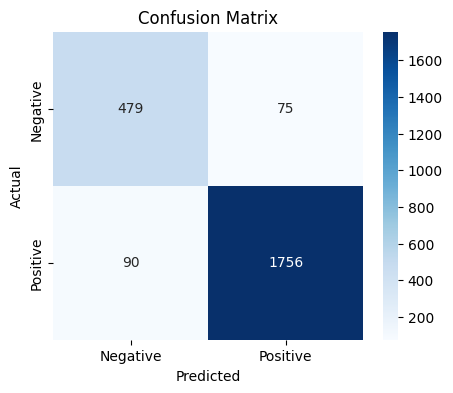

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch
import torch.nn.functional as F

# Load the trained model
model.load_state_dict(torch.load('bert_lstm_sentiment_model3.pth'))
model.to(device)
model.eval()

# Define a list of strong negative words
NEGATIVE_WORDS = {
    "horrible", "awful", "terrible", "disgusting", "dangerous", "unsafe", "reckless",
    "late", "dirty", "smelly", "slow", "frustrating", "disappointed", "rude", "overpriced"
}

# Function to calculate sentiment score with penalty
def get_sentiment_score(text, model, tokenizer, device):
    # Tokenize text
    sample_enc = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    sample_ids, sample_mask = sample_enc['input_ids'].to(device), sample_enc['attention_mask'].to(device)

    # Get model prediction
    with torch.no_grad():
        logits = model(sample_ids, sample_mask)
        probs = F.softmax(logits, dim=1)  # Convert logits to probabilities

    p_positive, p_negative = probs[0][1].item(), probs[0][0].item()
    sentiment_score = p_positive - p_negative  # Base sentiment score

    # Count negative words in the text
    words = text.lower().split()
    negative_count = sum(1 for word in words if word in NEGATIVE_WORDS)

    # Apply penalty (0.1 per negative word)
    penalty = 0.1 * negative_count
    adjusted_sentiment_score = sentiment_score - penalty

    # Scale sentiment score to 1-5 rating
    scaled_rating = 1 + 4 * ((adjusted_sentiment_score + 1) / 2)
    scaled_rating = max(1.0, min(5.0, scaled_rating))  # Ensure it stays in range

    return adjusted_sentiment_score, scaled_rating, probs.tolist()

# Example usage
text_samples = [
    "The driver was very professional and arrived on time. Smooth ride!",
    "Terrible experience! The driver was rude and the car smelled awful.",
    "The ride was okay, but the driver took a longer route than necessary.",
    "Loved the service! The car was clean, and the driver was super friendly.",
    "The app crashed, and I couldn't book a ride. Very frustrating!"
]

# Assume `model`, `tokenizer`, and `device` are already defined
for text in text_samples:
    sentiment_score, rating, probs = get_sentiment_score(text, model, tokenizer, device)
    print(f"Text: {text}")
    print(f"Sentiment Score: {sentiment_score:.2f}  (P(Positive) - P(Negative))")
    print(f"Predicted Rating (1-5): {rating:.2f}")
    print(f"Probability Scores: {probs}\n")



Text: The driver was very professional and arrived on time. Smooth ride!
Sentiment Score: 0.93  (P(Positive) - P(Negative))
Predicted Rating (1-5): 4.87
Probability Scores: [[0.03306959941983223, 0.9669304490089417]]

Text: Terrible experience! The driver was rude and the car smelled awful.
Sentiment Score: -0.18  (P(Positive) - P(Negative))
Predicted Rating (1-5): 2.65
Probability Scores: [[0.48861417174339294, 0.5113858580589294]]

Text: The ride was okay, but the driver took a longer route than necessary.
Sentiment Score: 0.74  (P(Positive) - P(Negative))
Predicted Rating (1-5): 4.48
Probability Scores: [[0.1295614391565323, 0.8704385757446289]]

Text: Loved the service! The car was clean, and the driver was super friendly.
Sentiment Score: 0.99  (P(Positive) - P(Negative))
Predicted Rating (1-5): 4.98
Probability Scores: [[0.006151094567030668, 0.993848979473114]]

Text: The app crashed, and I couldn't book a ride. Very frustrating!
Sentiment Score: -0.24  (P(Positive) - P(Negative